# Chapter 3

In the sheet we will explore the concept of blurring and convolving a matrix. Before applying the operations on images, we will look at small matrices and see what results they yield

In [1]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt

Let us first define a matrix of size 5 $\times$ 5 and all values be 5 in it. We will then define a kernel of size 3 $\times$ 3 and one filter of 5 $\times$ 5 and convolve it it this ``fivebyfive`` matrix. 

Before we invoke the convolve operation, lets see what convolve does. Take a look at the following image

![ConvolveVisual](ConvolveVisual.png)

- Suppose we have an n $\times$ n image and a k $\times$ k kernel (with k >= 0 and k is odd).

- We use the kernel as a weights matrix on a k $\times$ k part of the image and multiply the corresponding pixel in the image with the weight given at that location in the kernel.

- The image above shows us kernel with k = 3 and an image with n = 5. When we try to map this 3 $\times$ 3 kernel on 3 $\times$ 3 portion of the image, we have two conditions

    * The kernel completely fits in the image as shown in the first of the three images. This is an easy condition where we simply multiply the $i^{th}$ element of the kernel with the element in the corresponding position in the image. For the first example if we perform element wise multiplication of the colored portion of the image and the kernel we get the (5 $\times$ 0) + (5 $\times$ 1) + (5 $\times$ 0) + (5 $\times$ 1) + (5 $\times$ 2) + (5 $\times$ 1) + (5 $\times$ 0) + (5 $\times$ 1) + (5 $\times$ 0) = 30. The scalar value we get by this operation is the value of that one pixel at the center of the k $\times$ k patch in the image.
    
    * The above condition was straight forward. But what if a part of kernel goes outside the image as we see in the $2^{nd}$ and $3^{rd}$ image. In these case we need to make a special provision of padding the image with some value. That some value is configurable and ``ndimage.convolve`` by default uses the reflect mode which essentially reflects the contents at the border of the image outside (this is the  $3^{rd}$ case shown in the picture). Another option is setting the mode to ``constant`` which pads the image with a constant value. The constant value is determined by another parameter ``cval`` which defaults to 0. Similar to the above point, the values of 30 and 20 are computed respectively.





In [2]:
fivebyfive = np.zeros((5, 5)) + 5
threebythree_kernel = np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]])

In [3]:
ndimage.convolve(fivebyfive, threebythree_kernel, mode = 'reflect')

array([[ 30.,  30.,  30.,  30.,  30.],
       [ 30.,  30.,  30.,  30.,  30.],
       [ 30.,  30.,  30.,  30.,  30.],
       [ 30.,  30.,  30.,  30.,  30.],
       [ 30.,  30.,  30.,  30.,  30.]])

In [4]:
ndimage.convolve(fivebyfive, threebythree_kernel, mode = 'constant')

array([[ 20.,  25.,  25.,  25.,  20.],
       [ 25.,  30.,  30.,  30.,  25.],
       [ 25.,  30.,  30.,  30.,  25.],
       [ 25.,  30.,  30.,  30.,  25.],
       [ 20.,  25.,  25.,  25.,  20.]])

---
Let us now read an image usinh ``cv2.imread``. The second parameter can take following three values

* cv2.IMREAD_COLOR (-1): Loads a color image. Any transparency of image will be neglected. It is the default flag.
* cv2.IMREAD_GRAYSCALE (0): Loads image in grayscale mode
* cv2.IMREAD_UNCHANGED (1): Loads image as such including alpha channel

In [5]:
image = cv2.imread('python.png', cv2.IMREAD_GRAYSCALE)

In [6]:
image.shape

(64, 64)

Lets display this image

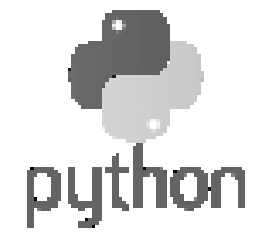

In [7]:
def displayImage(image, isbgr = False):
    image = image if not isbgr else cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)        
    plt.axis('off')
    plt.show()

displayImage(image)

Let is do a couple of things

* Apply a $3\times3$ kernel on the image and display it
* Apply a GaussianBlur on the image

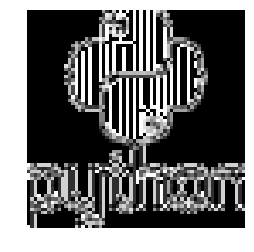

In [8]:
kernel = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
convolvedImage = ndimage.convolve(image, kernel)
displayImage(convolvedImage)

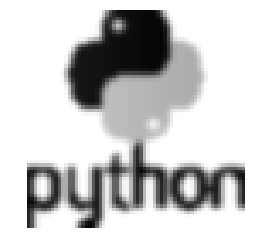

In [9]:
blurredImage = cv2.GaussianBlur(image, (5, 5), sigmaX = 1)
displayImage(blurredImage)

[Gaussian Blur](https://en.wikipedia.org/wiki/Gaussian_blur) is a convolution operator which uses the surrounding pixels in a weighted manner to compute a center pixel's value. The area of the kernel forms a gaussian distribution around the central point and the values in this gaussian distribution is used to produce the weights of the corresponding pixel value's contribution to the center pixel, further the pixel is from the current pixel, less it contributes. Typically after 3 standard deviations the contribution of the pixel value to the center pixel becomes 0.

The edges in the image represent high frequency. GaussianBlur acts as a Low Pass Filter and filters this high frequency signals allowing only the low frequency signals effectively blurring the image. This operation smoothes the image. Higher the value of the sigma provided to the Gaussian Kernel more smoothing effect it will have on the image

The previous convolution operator using the kernel ``[[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]`` enhanced the edges in the image. Thus this is a High Pass Filter and passes the high frequency signals suppressing low frequency signals

---

We will now now implement a function ``strokeEdge`` which will super impose edges of the source images on to the image.

The first step is to remove the noise in the image by blurring it to prevent the edge detection algorithm from misidentifying the noise as edge. We can use any blurring filter, but we will use median blur here

Next, once the blurring is done, we will use an edge detection filter to find the edges. The filter will pass high frequency signal though it suppressing low frequency signals. Thus, all edges will be white and remaining image will be black.

We will invert(make black white and white black) and normalize (convert all pixel values between 0 and 1) the image such that the $n\times n$ image and its bitmap containing the edge information can be multiplied such that the pixels of the source image having the edges will be darkned


First, lets capture the image and apply the ``strokeEdge`` function on it

In [23]:
capture = cv2.VideoCapture(0)
captured, image = capture.read()
capture.release()
assert captured, "Image not captured"

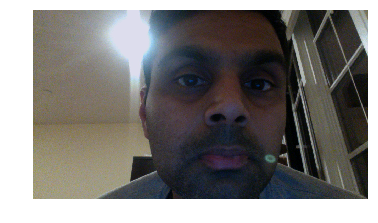

In [24]:
displayImage(image, isbgr = True)

Now that the image is captured, we will use this image for detecting edges. Lets define the function ``strokeEdge``

In [25]:
def strokeEdge(src, blurKSize = 7, strokeKSize = 5):
    if blurKSize >= 3:
        blurred = cv2.medianBlur(src, blurKSize)
        grayScale = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    else:
        grayScale = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        
    cv2.Laplacian(grayScale, cv2.CV_8U, grayScale, ksize = strokeKSize)
    normalizedInvertedAlpha = (255 - grayScale) * 1.0 / 255    
    result = src.copy()
    for i in range(0, 3):
        result[:, :, i] = result[:, :, i] * normalizedInvertedAlpha
        
    return result
    

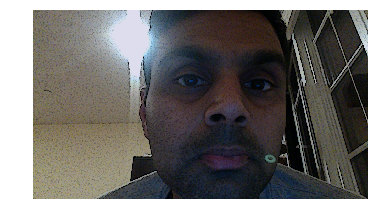

In [26]:
displayImage(strokeEdge(image), isbgr = True)

As we see in the above couple of images, the edges are seen darker and stroked in the image when compared to the source image. Following few points are interesting to note

Laplcian edge detection works best on grayscale images (as read in the book, I am yet to get the mathematical explanation for that). Thats the reason why we convert the image to gray scale before we apply the laplacian edge detection filter on it

